<a href="https://colab.research.google.com/github/Sompote/RIC_predict/blob/main/RIC_CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code is for a combindnation of LSTM and CON1D together to predict RIC
*   The feature was addinto the X_train in the [:,:,1:3] dimenssion
*   initial qc value is in [:,:,0]




In [1]:
#conv1D predict RIC combind model by Dr. Sompote Youwai 2023
import numpy as np
import pandas as pd

# Import libraries
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd



df = pd.read_excel('/content/drive/MyDrive/RIC/resilts_adjust.xlsx')
data=np.array(df)
X=data[:,1:18]
Y=data[:,20:34]


In [3]:
#scale data
X_train=X
Y_train=Y
sc_y=StandardScaler()
sc = StandardScaler()
sc_f=StandardScaler()
X_feature=X_train[:,14:17]
X_train=X_train[:,0:14]

X_train = sc.fit_transform(X_train)
y_train=sc_y.fit_transform(Y_train)
X_feature=sc_f.fit_transform(X_feature)




In [4]:
X_train_CNN=np.zeros((X_train.shape[0],X_train.shape[1],X_feature.shape[1]+1))
X_train_CNN[:,:,0]=X_train
for i in range(0,(X.shape[0])):
  X_train_CNN[i,:,1]=X_feature[i,0]
  X_train_CNN[i,:,2]=X_feature[i,1]
  X_train_CNN[i,:,3]=X_feature[i,2]

In [5]:
#split data
X_train, X_test, y_train, y_test = train_test_split(X_train_CNN, y_train, test_size=0.1)


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, Flatten, concatenate
from keras.layers import MaxPooling1D
from keras.layers import LSTM, Dense
from tensorflow.keras.metrics import MeanAbsolutePercentageError




def dens_model(dense_input_shape):
  # Create the dense model
  dense_input = Input(shape=dense_input_shape)
  dense_output = Dense(300, activation='sigmoid')(dense_input)
  dense_output = Dense(100, activation='sigmoid')(dense_output)
  dense_output = Dense(50, activation='linear')(dense_output)
  dense_model = Model(inputs=dense_input, outputs=dense_output)
  return dense_model

def feature_model(dense_input_shape):
  # Create the dense model
  dense_input = Input(shape=dense_input_shape)
  dense_output = Dense(50, activation='sigmoid')(dense_input)
  dense_output = Dense(20, activation='sigmoid')(dense_output)
  dense_output = Dense(5, activation='linear')(dense_output)
  dense_model = Model(inputs=dense_input, outputs=dense_output)
  return dense_model

def CNN_model(cnn_input_shape):
  # Create the CNN model
  cnn_input = Input(shape=cnn_input_shape)
  cnn_output = Conv1D(filters=32, kernel_size=3, activation='relu')(cnn_input)
  cnn_output= MaxPooling1D(pool_size=2)(cnn_output)
  cnn_output = Conv1D(filters=32, kernel_size=3, activation='relu')(cnn_input)
  cnn_output= MaxPooling1D(pool_size=2)(cnn_output)
  cnn_output = Flatten()(cnn_output)
  cnn_output = Dense(50, activation='linear')(cnn_output)
  cnn_model = Model(inputs=cnn_input, outputs=cnn_output)
  return cnn_model


def LSTM_model(dense_input_shape):
  # Create the dense model
  # Use the function parameter as the input shape
  dense_input = Input(shape=dense_input_shape)
  dense_output = LSTM(1000)(dense_input)
  dense_output = LSTM(500)(dense_input)
  dense_output = Dense(100, activation='sigmoid')(dense_output)
  dense_output = Dense(50, activation='linear')(dense_output)
  dense_model = Model(inputs=dense_input, outputs=dense_output)
  return dense_model


def combind_model(dense_model,cnn_model,y_train):
  combined_input_dense = dense_model.output
  combined_input_cnn = cnn_model.output
  combined_input_LSTM = LSTM_model.output
  combined_input = concatenate([combined_input_cnn,combined_input_dense])
  combined_output = Dense(y_train.shape[1], activation='linear')(combined_input)
  combined_model = Model(inputs=[cnn_model.input,dense_model.input], outputs=combined_output)
  return combined_model

def combind_model2(LSTM_model,cnn_model,y_train):
  combined_input_LSTM = LSTM_model.output
  combined_input_cnn = cnn_model.output
  combined_input = concatenate([combined_input_LSTM,combined_input_cnn])
  combined_output = Dense(y_train.shape[1], activation='linear')(combined_input)
  combined_model = Model(inputs=[LSTM_model.input,cnn_model.input], outputs=combined_output)
  return combined_model

# Compile and summarize the combined model
#Main program

dense_input_shape = (X_train.shape[1])
cnn_input_shape = (X_train.shape[1],X_train.shape[2])
LSTM_input_shape=(X_train.shape[1],X_train.shape[2])



model_cnn=CNN_model(cnn_input_shape)
model_lstm= LSTM_model(LSTM_input_shape)
model_combind=combind_model2(model_lstm,model_cnn,y_train)
model_combind.compile(optimizer='adam', loss='mse', metrics=['mape'])
model_combind.summary()
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='loss', patience=6,restore_best_weights=True)

history=model_combind.fit([X_train, X_train], y_train, epochs=600, batch_size=20,validation_data=([X_test,X_test], y_test))

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 14, 4)]      0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 14, 4)]      0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 12, 32)       416         ['input_1[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, 500)          1010000     ['input_2[0][0]']                
                                                                                            

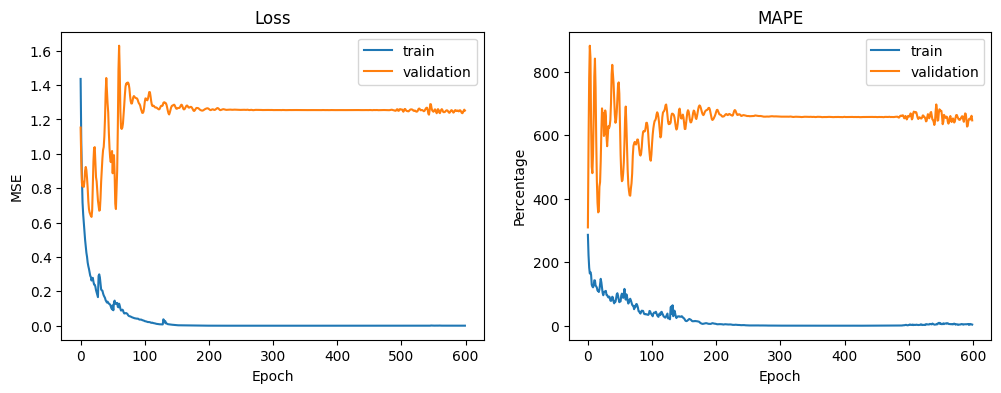

In [7]:

# plot the loss and mape for train and validation sets
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mape'], label='train')
plt.plot(history.history['val_mape'], label='validation')
plt.title('MAPE')
plt.xlabel('Epoch')
plt.ylabel('Percentage')
plt.legend()

plt.show()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 14, 4)]      0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 14, 4)]      0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 12, 32)       416         ['input_1[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, 500)          1010000     ['input_2[0][0]']                
                                                                                            

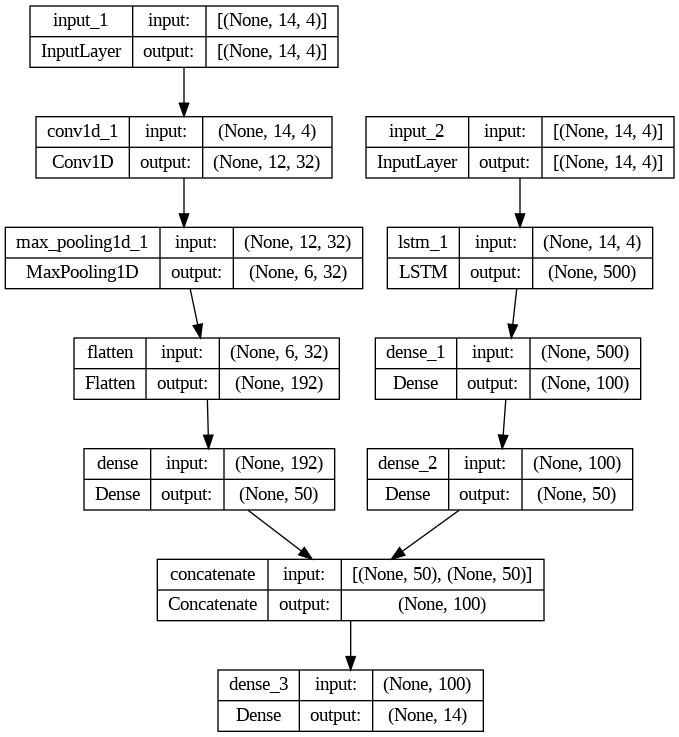

In [12]:
# plot and save your model
import tensorflow as tf
model_combind.summary()
img_file = 'model.png'
tf.keras.utils.plot_model(model_combind, to_file=img_file, show_shapes=True, show_layer_names=True)


In [9]:
#validation
x_predictn=np.zeros((1,14))
x_predictn[0,:]=[10,23,5,8,9,8,12,12,0.1,2,0.2,0.5,0.1,2]
X_predict = sc.transform(x_predictn)
x_feature=np.zeros((1,3))
x_feature[0,0]=50 #blow
x_feature[0,1]=30 #fine
x_feature[0,2]=3 #thickness
X_feature = sc_f.transform(x_feature)
#set up calculation matrix
x_cal=np.zeros((1,14,4))
x_cal[:,:,0]=X_predict
x_cal[:,:,1]=X_feature[0,0]
x_cal[:,:,2]=X_feature[0,1]
x_cal[:,:,3]=X_feature[0,2]
y=model_combind.predict([x_cal,x_cal])
y=sc_y.inverse_transform(y)
print(y)
#plot


1/1 [==============================] - 0s 488ms/step
[[ 0.86522025 10.654773   13.675727   13.992891   14.620696    7.637465
   4.82821    10.80215     1.6675705  12.362365    9.574354    9.733542
   2.5526555   0.6501197 ]]


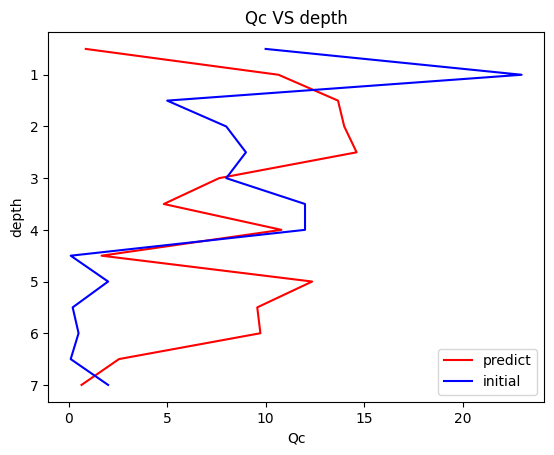

In [10]:
import matplotlib.pyplot as plt

# Define the x-axis and corresponding y-axis values as lists

ydist=[0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7]


# Plot them on canvas using plt.plot() function
plt.plot(y[0,:], ydist,color='red',label='predict')
plt.plot(x_predictn[0,:], ydist,color='blue',label='initial')
plt.legend()


# Give a name to x-axis and y-axis using plt.xlabel() and plt.ylabel() functions
plt.xlabel("Qc")
plt.ylabel("depth")

# Give a title to your plot using plt.title() function
plt.title("Qc VS depth")
# Get the current axes instance
ax = plt.gca()

# Invert the y-axis
ax.invert_yaxis()

# Finally, to view your plot, we use plt.show() function
plt.show()